In [1]:
import torch
import gpytorch
import numpy as np
import pandas as pd

from bo_functions import calc_y_exp
from bo_functions import create_y_data
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_ei_basic
from bo_functions import eval_GP_basic_tot
from bo_functions import create_sse_data

from bo_plotters import plot_hyperparams
from bo_plotters import plot_xy
from bo_plotters import y_plotter
from bo_plotters import stdev_plotter
from bo_plotters import ei_plotter

In [2]:
#Pull x data from CSV
Theta_True = np.array([1,-1])
noise_std = 0.1**2
q = 2

exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)
# print(x)

In [3]:
#Pull training data from CSV
train_data_doc = "train_2_in_data.csv"
train_data = np.array(pd.read_csv(train_data_doc, header=0,sep=","))
train_T = torch.tensor(train_data[:,1:3])
train_sse = torch.tensor(train_data[:,3])
# print(train_sse)

In [4]:
#Reduce Number of Training Points
t =len(train_T) #Desired number of training points
t = 3 #Set t=5 to show changing EI
train_T = train_T[0:t]
train_sse = train_sse[0:t]

In [5]:
#Define GP Testing space
#Define Testing Space
p=10
Theta1 =  np.linspace(0,2,p) #1x10
Theta2 =  np.linspace(-2,0,p) #1x10
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
theta1_mesh = theta_mesh[0]
theta2_mesh = theta_mesh[1]
# print(theta_mesh)

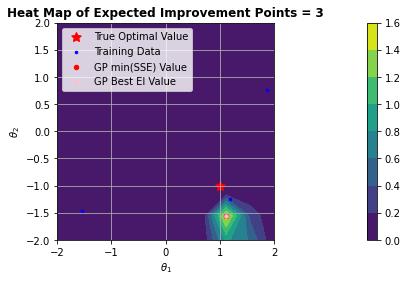

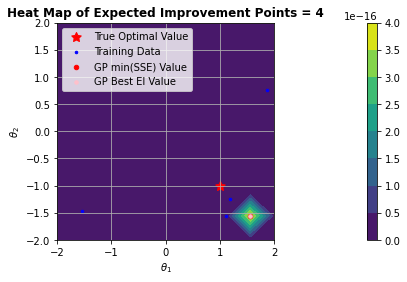

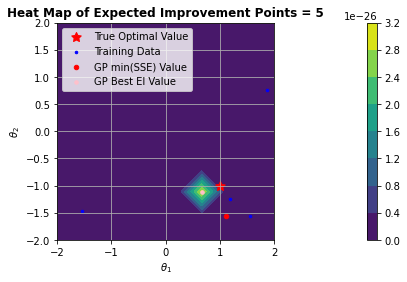

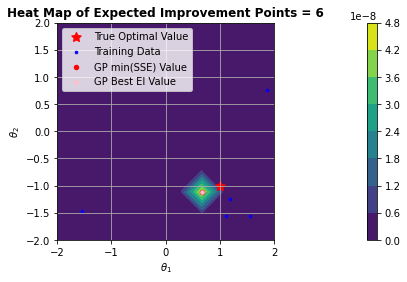

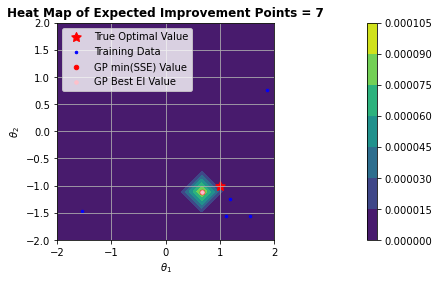

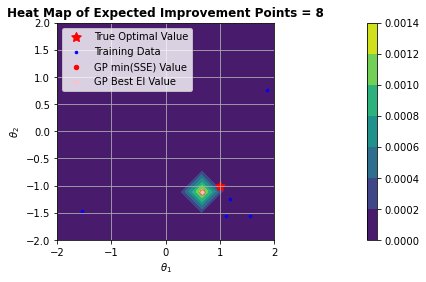

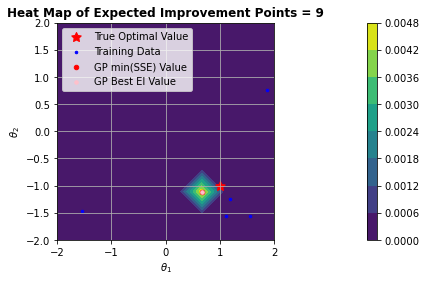

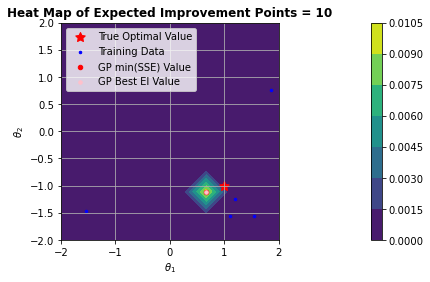

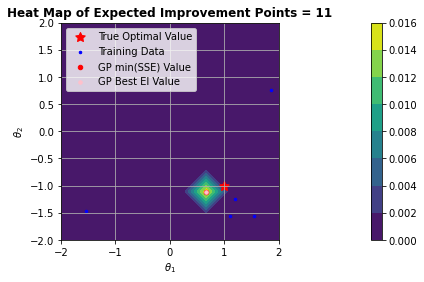

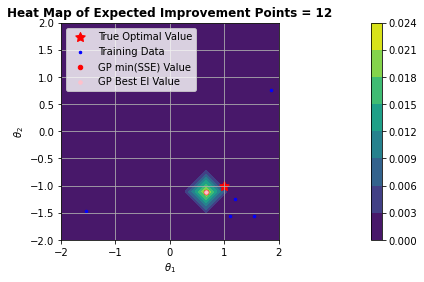

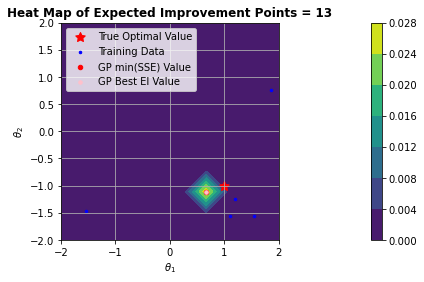

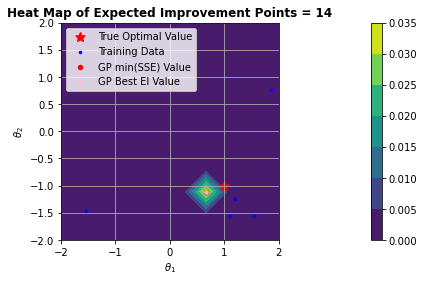

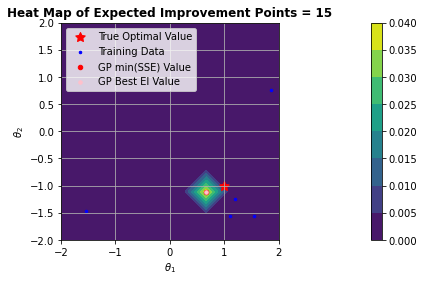

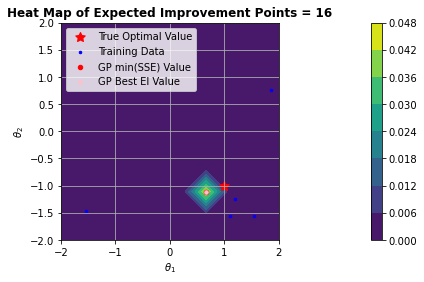

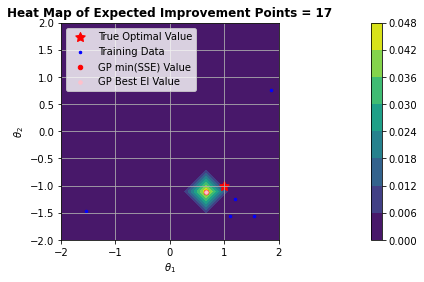

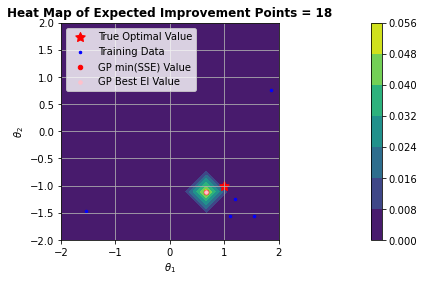

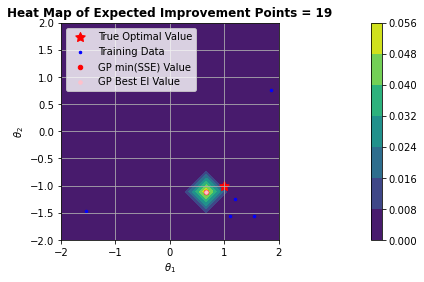

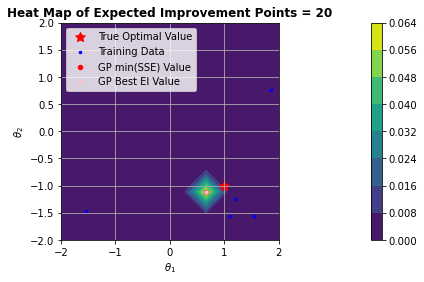

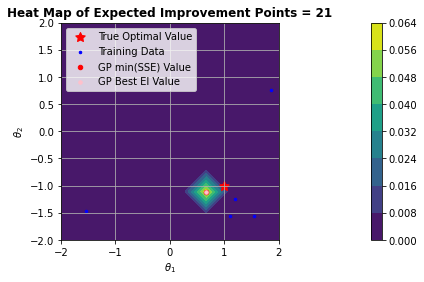

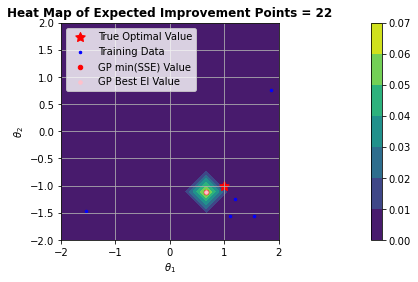

In [6]:
#Training the GP Model
iterations = 300
explore_bias = 0
verbose = True

BO_iter = 5

train_T_dict = {}
train_sse_dict = {}
ei_dict = {}
sse_dict ={}
var_dict ={}
GP_mean_best_dict = {}
GP_var_best_dict = {}
GP_mean_min_dict ={}
GP_var_min_dict = {}
Theta_Opt_dict = {}
Theta_Best_dict = {}
Best_Error_dict = {}
if verbose == True:
    z_dict = {}
    ei_term_1_dict = {}
    ei_term_2_dict = {}
    CDF_dict = {}
    PDF_dict = {}

for i in range(BO_iter):
    if torch.is_tensor(train_T) != True:
        train_T = torch.from_numpy(train_T)
    if torch.is_tensor(train_sse) != True:
        train_sse = torch.from_numpy(train_sse)
    
    train_T_dict[i+1] = train_T
    train_sse_dict[i+1] = train_sse
    # initialize likelihood and model
    ##Assumes a homoskedastic noise model p(y | f) = f + noise
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    # We will use the simplest form of GP model, exact inference
    #Defines our model in terms of the class parameters in bo_functions
    model = ExactGPModel(train_T, train_sse, likelihood)
    train_GP = train_GP_model(model, likelihood, train_T, train_sse, iterations, verbose = False)
    
    ##Set Hyperparameters to 1
    outputscale = torch.tensor([1])
    lengthscale = torch.tensor([1])
    noise = torch.tensor([0.1])

    model.likelihood.noise = noise
    model.covar_module.base_kernel.lengthscale =lengthscale
    model.covar_module.outputscale = outputscale

    
    model.eval()
    #Puts likelihood in evaluation mode
    likelihood.eval()

    #Same point keeps being selected, should I remove that point by force?
    ei_components = eval_GP_basic_tot(p,theta_mesh, train_sse, model, likelihood, explore_bias, verbose)
    ei = ei_components[0]
    sse = ei_components[1]
    var = ei_components[2]
    stdev = ei_components[3]
    best_error = ei_components[4]
    if verbose == True:
        z = ei_components[5]
        ei_term_1 = ei_components[6]
        ei_term_2 = ei_components[7]
        CDF = ei_components[8]
        PDF = ei_components[9]
    
    ei_dict[i+1] = ei
    sse_dict[i+1] = sse
    var_dict[i+1] = var
    z_dict[i+1]=z
    Best_Error_dict[i+1] = best_error
    ei_term_1_dict[i+1] = ei_term_1
    ei_term_2_dict[i+1] = ei_term_2
    CDF_dict[i+1] = CDF
    PDF_dict[i+1] = PDF

    #Finds the index where sse is the smallest and finds which Theta combination corresponds to that value
    argmin = np.array(np.where(np.isclose(sse, np.amin(sse),atol=np.amin(sse)*1e-6)==True))
    Theta_1_Opt = float(theta1_mesh[argmin[0],argmin[1]])
    Theta_2_Opt = float(theta2_mesh[argmin[0],argmin[1]])
    Theta_Opt_GP = np.array((Theta_1_Opt,Theta_2_Opt))
    
    #calculates best theta value
    argmax = np.array(np.where(np.isclose(ei, np.amax(ei),atol=np.amax(ei)*1e-6)==True))
#     print(argmax)
    if len(argmax[0]) != 1:
        argmax = np.array([[argmax[0,1]],[argmax[1,1]]])
        
        
    Theta_1_Best = float(theta1_mesh[argmax[0],argmax[1]])
    Theta_2_Best = float(theta2_mesh[argmax[0],argmax[1]])
    Theta_Best = np.array((Theta_1_Best,Theta_2_Best))    
    
    Theta_Opt_dict[i+1] = Theta_Opt_GP
    Theta_Best_dict[i+1] = Theta_Best

    GP_mean_min = sse[argmin[0],argmin[1]]
    GP_var_min = (stdev[argmin[0],argmin[1]])**2
    GP_mean_best = sse[argmax[0],argmax[1]]
    GP_var_best = (stdev[argmax[0],argmax[1]])**2
    
    GP_mean_best_dict[i+1] = GP_mean_best
    GP_var_best_dict[i+1] = GP_var_best
    GP_mean_min_dict[i+1] = GP_mean_min
    GP_var_min_dict[i+1] = GP_var_min
    
    ei_plotter(theta_mesh, ei, Theta_True, Theta_Opt_GP, Theta_Best,train_T,plot_train=True)
    ##Append best values to training data 
    #Convert training data to numpy arrays to allow concatenation to work
    train_T = train_T.numpy() #(q x t)
    train_sse = train_sse.numpy() #(1 x t)

    #Call the expensive function and evaluate at Theta_Best
    sse_Best = create_sse_data(q,Theta_Best, Xexp, Yexp) #(1 x 1)
 
    #Add Theta_Best to train_p and y_best to train_y
    train_T = np.concatenate((train_T, [Theta_Best]), axis=0) #(q x t)
    train_sse = np.concatenate((train_sse, [sse_Best]),axis=0) #(1 x t)
    


In [7]:
print(train_T_dict)
print(train_sse_dict)

#This is Expected

{1: tensor([[ 1.8567,  0.7658],
        [-1.5359, -1.4589],
        [ 1.1929, -1.2549]], dtype=torch.float64), 2: tensor([[ 1.8567,  0.7658],
        [-1.5359, -1.4589],
        [ 1.1929, -1.2549],
        [ 1.1111, -1.5556]], dtype=torch.float64), 3: tensor([[ 1.8567,  0.7658],
        [-1.5359, -1.4589],
        [ 1.1929, -1.2549],
        [ 1.1111, -1.5556],
        [ 1.5556, -1.5556]], dtype=torch.float64), 4: tensor([[ 1.8567,  0.7658],
        [-1.5359, -1.4589],
        [ 1.1929, -1.2549],
        [ 1.1111, -1.5556],
        [ 1.5556, -1.5556],
        [ 0.6667, -1.1111]], dtype=torch.float64), 5: tensor([[ 1.8567,  0.7658],
        [-1.5359, -1.4589],
        [ 1.1929, -1.2549],
        [ 1.1111, -1.5556],
        [ 1.5556, -1.5556],
        [ 0.6667, -1.1111],
        [ 0.6667, -1.1111]], dtype=torch.float64), 6: tensor([[ 1.8567,  0.7658],
        [-1.5359, -1.4589],
        [ 1.1929, -1.2549],
        [ 1.1111, -1.5556],
        [ 1.5556, -1.5556],
        [ 0.6667, -1.1111]

In [8]:
print("Max EIs")
print(np.amax(ei_dict[1]))
print(np.amax(ei_dict[2]))
print(np.amax(ei_dict[3]))

#EIs are expected

print("\nMin SSEs")
print(np.amin(sse_dict[1]))
print(np.amin(sse_dict[2]))
print(np.amin(sse_dict[3]))

##These are expected

print("\nBest EI GP Mean/Var")
print(GP_mean_best_dict)
print(GP_var_best_dict)

#GP Mean and EI Best vs Opt is the same. What does this mean?

print("\nLowest SSE GP Mean/Var")
print(GP_mean_min_dict)
print(GP_var_min_dict)

#Expected based on results above

print("\nTheta @ Lowest SSE")
print(Theta_Opt_dict)

#Expected based on results above
print("\nTheta @ Highest EI")
print(Theta_Best_dict)


print("z values")
print(z_dict[1],"\n", z_dict[2],"\n",z_dict[3])


print("Term 1 values")
print(ei_term_1_dict[1],"\n", ei_term_1_dict[2],"\n",ei_term_1_dict[3])

print("Term 2 values")
print(ei_term_2_dict[1],"\n", ei_term_2_dict[2],"\n",ei_term_2_dict[3])

print("CDF")
print(CDF[1],"\n", CDF[2],"\n",CDF[3])

print("PDF")
print(PDF[1],"\n", PDF[2],"\n",PDF[3])

Max EIs
1.4949674588160426
3.8476400140064584e-16
2.9528413597847216e-26

Min SSEs
1.0530543802246832
6.844948839740535
8.06814333292894

Best EI GP Mean/Var
{1: array([1.05305438]), 2: array([6.84494884]), 3: array([8.62100176]), 4: array([3.48300314]), 5: array([2.63940913]), 6: array([2.29328079]), 7: array([2.10485504]), 8: array([1.98636589]), 9: array([1.9049759]), 10: array([1.8456215]), 11: array([1.80042146]), 12: array([1.76485244]), 13: array([1.73613272]), 14: array([1.71245779]), 15: array([1.69260584]), 16: array([1.67572001]), 17: array([1.66118186]), 18: array([1.6485336]), 19: array([1.63742913]), 20: array([1.62760218])}
{1: array([0.27353326]), 2: array([0.30930648]), 3: array([0.35024283]), 4: array([0.17144837]), 5: array([0.1416734]), 6: array([0.12941512]), 7: array([0.12272927]), 8: array([0.11851984]), 9: array([0.11562594]), 10: array([0.11351422]), 11: array([0.11190531]), 12: array([0.11063873]), 13: array([0.10961574]), 14: array([0.10877222]), 15: array([0

In [9]:
for i in range(BO_iter):
    j = i+1
    argmax = np.array(np.where(np.isclose(ei_dict[j], np.amax(ei_dict[j]),atol=np.amax(ei_dict[j])*1e-6)==True))
    f_Best_a = best_error[argmax[0],argmax[1]][0]
    print("f_Best",f_Best_a)
    print("GP Mean/Var:",GP_mean_best_dict[j],GP_var_best_dict[j])
    print("EI_max:",np.amax(ei_dict[j]))
    print("EI:",calc_ei_basic(f_Best_a,-GP_mean_best_dict[j],GP_var_best_dict[j], explore_bias), "\n")


f_Best -1.4665230205436055
GP Mean/Var: [1.05305438] [0.27353326]
EI_max: 1.4949674588160426
EI: [0.4773897] 

f_Best -1.4665230205436055
GP Mean/Var: [6.84494884] [0.30930648]
EI_max: 3.8476400140064584e-16
EI: [1.13068579e-23] 

f_Best -1.4665230205436055
GP Mean/Var: [8.62100176] [0.35024283]
EI_max: 2.9528413597847216e-26
EI: [2.91347004e-35] 

f_Best -1.4665230205436055
GP Mean/Var: [3.48300314] [0.17144837]
EI_max: 4.4098597482866614e-08
EI: [4.40985975e-08] 

f_Best -1.4665230205436055
GP Mean/Var: [2.63940913] [0.1416734]
EI_max: 9.48836546331858e-05
EI: [9.48836546e-05] 

f_Best -1.4665230205436055
GP Mean/Var: [2.29328079] [0.12941512]
EI_max: 0.0013242324997857994
EI: [0.00132423] 

f_Best -1.4665230205436055
GP Mean/Var: [2.10485504] [0.12272927]
EI_max: 0.004729594961509299
EI: [0.00472959] 

f_Best -1.4665230205436055
GP Mean/Var: [1.98636589] [0.11851984]
EI_max: 0.009861618954972541
EI: [0.00986162] 

f_Best -1.4665230205436055
GP Mean/Var: [1.9049759] [0.11562594]
EI_m

[ 0.66666667 -1.11111111]


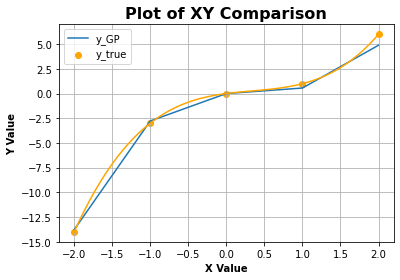

In [10]:
q_y = 3
y_GP_input = np.zeros((n,3))
for j in range(n):
    y_GP_input[j] = np.array([Theta_Best[0],Theta_Best[1],Xexp[j]])

y_GP_Opt = create_y_data(q_y,y_GP_input)
print(Theta_Opt_GP)

title = "XY Comparison"
plot_xy(Xexp, Yexp, y_GP_Opt,Theta_True,title)